# CNN using Tensorflow Keras on MRI Image Data

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

## Setup

### Imports

In [1]:
import nibabel.freesurfer.mghformat as mgh

from tqdm.notebook import tqdm

import os, sys, shutil

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
pd.set_option('display.max_colwidth', None)

### Set up and test Tensorflow

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Pandas 1.3.0
Found GPU at: /device:GPU:0


## Load data

### MRI scans
Since all the files are already transformed via the freesurfer, I don't think we'll need to do any major preprocessing like cropping, flipping, or rotating.
```
main_directory/
    control/
        mr_id_001/
            brain_image_001.mgz
            brain_image_001_transformed.mgz
            talairach_001.xfm
        mr_id_002/
            brain_image_002.mgz
            brain_image_002_transformed.mgz
            talairach_002.xfm
    dementia/
        mr_id_003/
            brain_image_003.mgz
            brain_image_003_transformed.mgz
            talairach_003.xfm
        mr_id_004/
            brain_image_004.mgz
            brain_image_004_transformed.mgz
            talairach_004.xfm
```

#### Define some flags for general use

In [4]:
# This class allows you to access dictionary items with a dot
# Gathered from here: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [5]:
FLAGS = {
    'scan_width'  : 256,
    'scan_height' : 256,
    'scan_depth'  : 256,
    # 'data_dir'    : '/content/drive/MyDrive/Extracurriculars/Summer_2021/Polygence/Data/OASIS/mri_data',  # use this if mounting on drive
    'data_dir'    : '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data',  # use this if on jupyter
    'num_class'   : 2,
    'batch_size'  : 8
}
FLAGS = dotdict(FLAGS)
print(FLAGS)

{'scan_width': 256, 'scan_height': 256, 'scan_depth': 256, 'data_dir': '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', 'num_class': 2, 'batch_size': 8}


#### Generate the filenames
The returned filenames list will be organized as follows:
```
[[path_to_scan_1, label_for_scan_1],
 [path_to_scan_2, label_for_scan_2],
 [path_to_scan_3, label_for_scan_3],
 ...
 [path_to_scan_n, label_for_scan_n]]

```

In [6]:
def generate_filenames(labels=['control', 'dementia'], random_state=1337):
    pairs = []
    
    for label in labels:
        label_dir = os.path.join(FLAGS.data_dir, label)
        mr_ids = os.listdir(label_dir)
        mr_ids.sort()
        
        for mr_id in tqdm(mr_ids, desc=label):
            scans = os.path.join(label_dir, mr_id)
            img_file = [file for file in os.listdir(scans) if "transformed" in file]
            img_path = os.path.join(scans, img_file[0])
            i = 1 if label == 'dementia' else 0
            pairs.append([img_path, i])
            
    random.Random(random_state).shuffle(pairs)
    
    m = len(pairs)
    filenames = []
    labels = np.zeros((m, 1), dtype='int32')
    
    idx = 0
    for filename, label in pairs:
        filenames.append(filename)
        labels[idx, 0] = label
        idx += 1
    
    filenames = np.array(filenames)
    return filenames, labels
        

X_filenames, y_labels = generate_filenames(random_state=1337)

control:   0%|          | 0/712 [00:00<?, ?it/s]

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

### Split into training and testing set

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [8]:
X_filenames_shuffled, y_labels_shuffled = shuffle(X_filenames, y_labels, random_state=1337)

In [9]:
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(
    X_filenames_shuffled, y_labels_shuffled, test_size=.2, random_state=1337)

In [10]:
print(X_train_filenames.shape, y_train.shape)
print(">> train >> ", X_train_filenames[0], y_train[0])
print(X_test_filenames.shape, y_test.shape)
print(">> test >> ", X_test_filenames[5], y_test[5])

(817,) (817, 1)
>> train >>  /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30288_MR_d0897/OAS30288_Freesurfer50_d0897_brain_transformed.mgz [0]
(205,) (205, 1)
>> test >>  /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30479_MR_d1266/OAS30479_Freesurfer53_d1266_brain_transformed.mgz [1]


### Create a custom generator
Since the data is too large to fit it all into memory, we will have to read it in batches.

In [11]:
from skimage.transform import resize, rescale

In [12]:
class MRI_Data_Generator(keras.utils.Sequence):
    """
    A data generator that reads MRI data in batches, and returns their image data
    """
    
    def __init__(self, filenames, labels, batch_size):
        """
        Intializes the generator
        :param filenames: list containing the path to each MRI scan file, should be np.ndarray
        :param labels: labels associated with the scans in filenames (control, dementia), should be np.ndarray
        :param batch_size: the size of the batch
        """
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        
    def __len__(self):
        """
        Calculate the number of batches that we are supposed to produce.
        Returns a rounded-up integer of total number of filenames divided by batch size.
        """
        return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(np.int)
        
    def __getitem__(self, idx):
        """
        Scan the data within that batch
        :param idx: the index of the batch to be selected
        """
        # Read in the items at that batch index
        # Since these two arrays are np arrays, we don't have to worry about index_out_of_bounds
        batch_X = self.filenames[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_y = self.labels[idx*self.batch_size : (idx+1)*self.batch_size]
        
        # Data preprocessing
        def normalize(volume):
            """ Normalize the volume, scaling it to [0, 1] instead of [0, 255] """
            min = 0.0
            max = 255.0
            volume[volume < min] = min
            volume[volume > max] = max
            volume = (volume - min) / (max - min)
            volume = volume.astype("float32")
            return volume

        def scale(volume):
            """ Reduce the volume from (256,256,256) to (128,128,128) """
            return resize(volume, (64,64,64))
            # return rescale(volume, 0.5)
        
        # print(f'Currently reading in batch {idx}')
        
        batch_X_data = []
        for filename in batch_X:
            rem_fs = filename[:filename.rfind("/")]
            rem_fs = rem_fs[rem_fs[:rem_fs.rfind("/")].rfind("/")+1:]
#             print(f'Currently reading in batch {idx}: {rem_fs}')
            
            MRI_orig = mgh.load(filename)
            volume = MRI_orig.get_fdata()
            volume = normalize(volume)
            volume = scale(volume)
            batch_X_data.append(volume)
        
        np_res_X = np.array(batch_X_data)
        np_res_y = np.array(batch_y)
        # print(f'Shapes: x - {np_res_X.shape}, y - {np_res_y.shape}')
        return np_res_X, np_res_y

### Test our data generator

In [13]:
test_gen = MRI_Data_Generator(X_train_filenames, y_train, 4)

In [14]:
batchx, batchy = test_gen.__getitem__(0)
print(">> Num of batches >> ", test_gen.__len__())  # outputs 164, which is equal to ceil(817 / 5)

>> Num of batches >>  205


In [15]:
print(batchx.shape, batchy.shape)
print(batchy)

(4, 64, 64, 64) (4, 1)
[[0]
 [1]
 [0]
 [0]]


#### Plot the generated results

In [16]:
# Parameters for graph
nrows = 3
ncols = 4

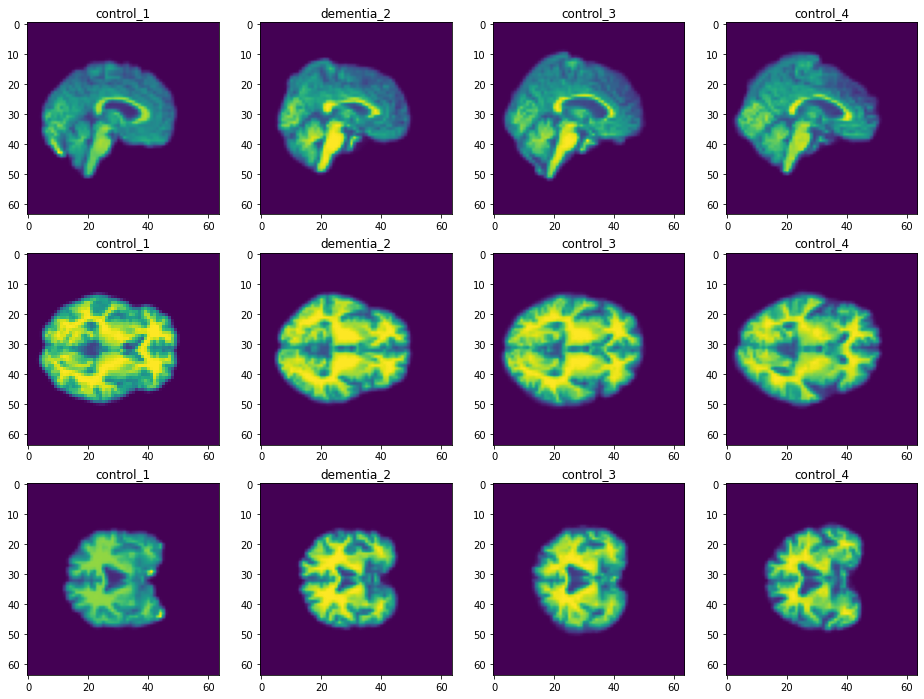

In [17]:
# Set up figure and plot it
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i in range(4):
    sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][32,:,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][:,32,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4 + 4)
    img = batchx[i][:,:,32]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')

In [18]:
print(batchx[i].shape)

(64, 64, 64)


In [19]:
# delete them to save memory
del batchx, batchy, test_gen

### Create our data generators for TF

In [20]:
training_batch_generator = MRI_Data_Generator(X_train_filenames, y_train, FLAGS.batch_size)
testing_batch_generator = MRI_Data_Generator(X_test_filenames, y_test, FLAGS.batch_size)

## CNN Model
We will have one convolutional layer, a maxpooling layer, then a final dense classification layer

Resources used:
* https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130
* https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71

### Create the model

In [21]:
def create_model():
    # The input is 128x128x128x1: 128x128x128 for each scan, and 1 for the channel
    inputs = keras.Input((128, 128, 128, 1))
    
    # This layer is a Conv3D layer that extracts 32 filters with a 5x5 window
    x = layers.Conv3D(filters=32, kernel_size=5, activation="relu")(inputs)
    
    # The second layer is a max-pooling layer with a 2x2 window for down sampling
    # I'm a little unsure of what max-pooling does exactly, but every resource I've seen used it after the Conv layer
    x = layers.MaxPool3D(pool_size=2)(x)
    
    # Normalizes the batch
    x = layers.BatchNormalization()(x)
    
    # Dropout layer to prevent overfitting
    # I'm also a little unsure with this, but again, every resource has used it
    x = layers.Dropout(0.25)(x)
    
    # I don't know what this does exactly, but it doesn't work without it.
    # I got this from here: https://keras.io/examples/vision/3D_image_classification/
    x = layers.GlobalAveragePooling3D()(x)

    # Fully connected layers
    # In general, is going from 512 -> 1 too much of a sharp drop?
    # x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    # Classification/output layer
    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    
    # Define the model
    model = keras.Model(inputs, outputs, name="3d-mri-cnn")
    return model

In [22]:
model = create_model()
model.summary()

Model: "3d-mri-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 124, 124, 124, 32) 4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 62, 62, 62, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 62, 32)    128       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 62, 32)    0         
_________________________________________________________________
global_average_pooling3d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8

#### Useful metrics
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#understanding_useful_metrics

* False negatives and false positives are samples that were incorrectly classified
* True negatives and true positives are samples that were correctly classified
* Accuracy is the percentage of examples correctly classified
* Precision is the percentage of predicted positives that were correctly classified
* Recall is the percentage of actual positives that were correctly classified
* AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-* AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
* AUPRC refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.


In [23]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [24]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [25]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
  loss=keras.losses.BinaryCrossentropy(),
  metrics=METRICS)

### Train the model

#### Set up Tensorboard

In [26]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

In [27]:
from datetime import datetime
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = 2)

In [28]:
%tensorboard --logdir=logs --port=8008

#### Fit the model

#### Create class weights, since there are less dementia samples than there are control

In [29]:
(unique, counts) = np.unique(y_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 712]
 [  1 310]]
69.67% of the data is control


In [30]:
# 0 is control, 1 is dementia
control_cnt = frequencies[0,1]
dementia_cnt = frequencies[1,1]
total_cnt = control_cnt + dementia_cnt
print(control_cnt, dementia_cnt, total_cnt)

712 310 1022


In [31]:
weight_for_0 = (1 / control_cnt) * (total_cnt / 2.0)
weight_for_1 = (1 / dementia_cnt) * (total_cnt / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.7176966292134831, 1: 1.6483870967741936}


#### Early stopping to avoid overfitting

In [32]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     verbose=1,
                                                     restore_best_weights=True)

In [33]:
history = model.fit(
            training_batch_generator,
            steps_per_epoch = int(X_train_filenames.shape[0] // FLAGS.batch_size),  # samples = batch_size * steps
            epochs = 50,
            verbose = 1,
            validation_data = testing_batch_generator,
            validation_steps = int(X_test_filenames.shape[0] // FLAGS.batch_size),  # samples = batch_size * steps
            callbacks = [tboard_callback, early_stopping_cb],
            class_weight = class_weight,
            use_multiprocessing = True,
            workers = 6,
            max_queue_size = 30)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
102/102 [==============================] - 202s 2s/step - loss: 0.6936 - tp: 163.0000 - fp: 200.0000 - tn: 358.0000 - fn: 88.0000 - accuracy: 0.6440 - precision: 0.4490 - recall: 0.6494 - auc: 0.6786 - prc: 0.4777 - val_loss: 0.6792 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 146.0000 - val_fn: 54.0000 - val_accuracy: 0.7300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5218 - val_prc: 0.3243
Epoch 2/50
102/102 [==============================] - 205s 2s/step - loss: 0.6837 - tp: 163.0000 - fp: 181.0000 - tn: 378.0000 - fn: 87.0000 - accuracy: 0.6687 - precision: 0.4738 - recall: 0.6520 - auc: 0.7152 - prc: 0.5106 - val_loss: 0.6592 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 146.0000 - val_fn: 54.0000 - val_accuracy: 0.7300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7929 - val_prc:

### Evaluate the model

#### Plot loss and accuracy

In [ ]:
# Set up figure and plot it
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i in range(4):
    sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][32,:,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][:,32,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4 + 4)
    img = batchx[i][:,:,32]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')

In [49]:
def plot_metrics(history):
    
    fig = plt.gcf()
    fig.set_size_inches(20, 3 * 4)

    metrics = ['auc','accuracy','loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        sp = plt.subplot(2, 3, n + 1)
        plt.plot(history.epoch, history.history[metric], color='C0', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='C1', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)

        plt.legend()

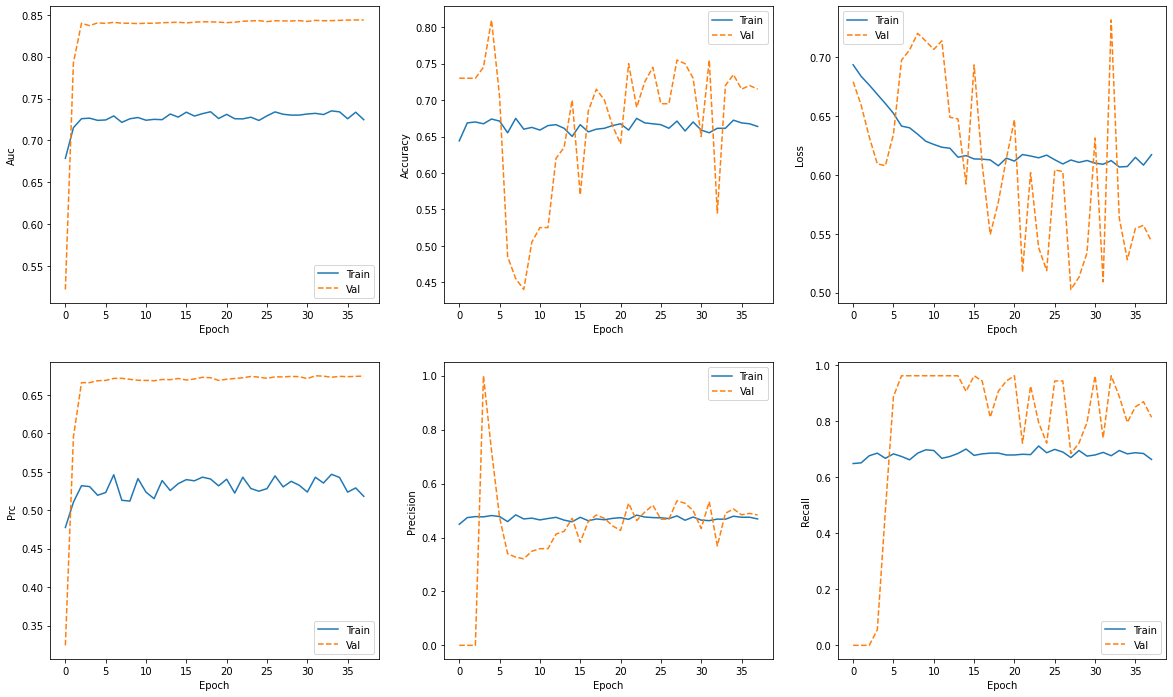

In [50]:
plot_metrics(history)

#### Save the model

In [51]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


#### Create a confusion matrix

In [57]:
raw_predictions = model.predict(
    testing_batch_generator, verbose=1, max_queue_size=30,
    workers=6, use_multiprocessing=True
)

26/26 [==============================] - 39s 1s/step


In [65]:
predictions = np.round(raw_predictions)

In [66]:
print(predictions[:5])

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [60]:
print(raw_predictions[:5])

[[0.2222072 ]
 [0.66882676]
 [0.45368144]
 [0.2663248 ]
 [0.30307028]]


Accuracy: 0.7609756097560976


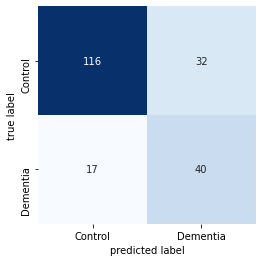

In [67]:
from sklearn.metrics import confusion_matrix
correct_preds = np.sum(predictions == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, predictions)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');

In [72]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "3d-mri-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 124, 124, 124, 32) 4032      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 62, 62, 62, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 62, 32)    128       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 62, 32)    0         
_________________________________________________________________
global_average_pooling3d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8

In [73]:
raw_predictions = new_model.predict(
    testing_batch_generator, verbose=1, max_queue_size=30,
    workers=6, use_multiprocessing=True
)
predictions = np.round(raw_predictions)

26/26 [==============================] - 40s 1s/step


Accuracy: 0.7609756097560976


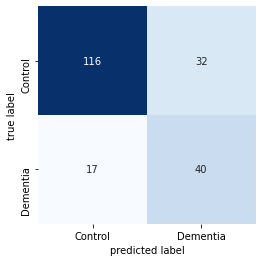

In [70]:
from sklearn.metrics import confusion_matrix
correct_preds = np.sum(predictions == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, predictions)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');